## Data preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import math
from scipy import stats
from itertools import product
import statsmodels.api as sm
import warnings
from dateutil.relativedelta import relativedelta

In [3]:
# read train data from given csv
df = pd.read_csv("/content/drive/My Drive/train_data.csv")
df

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...
...,...,...,...,...,...,...,...,...,...,...,...,...
8526521,1565978400,30.324878,59.932612,48,0,15,2,0,0,0,1,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526522,1565978400,30.324878,59.932612,20,1,0,0,0,0,0,0,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526523,1565978400,30.324878,59.932612,54,2,75,7,0,0,0,6,0101000020E61000005DECCB372B533E40494A4ED65FF7...
8526524,1565971200,30.324878,59.932612,15,0,350,4,25,0,0,0,0101000020E61000005DECCB372B533E40494A4ED65FF7...


In [4]:
# filter extemal values
extremes = (29.40635082565253 > df.lon) | (df.lon > 32.047397760963925) | (59.656929822910136 > df.lat) | (df.lat > 60.374089897957774)
print(sum(extremes), sum(extremes) / len(df))
df = df[~extremes]

75894 0.008900928701794845


In [5]:
df["date"] = pd.to_datetime(df["timestamp"], unit="s")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 8450632
unique                   9504
top       2019-08-25 18:00:00
freq                     2745
first     2019-01-01 00:00:00
last      2020-01-31 23:00:00
Name: date, dtype: object

In [7]:
df["day_id"] = (df.date.dt.date - df.date.min().date()).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Validation data

In [8]:
valid = pd.read_csv("/content/drive/My Drive/test.csv")
extremes = (29.40635082565253 > valid.lon) | (valid.lon > 32.047397760963925) | (59.656929822910136 > valid.lat) | (valid.lat > 60.374089897957774)
print(sum(extremes), sum(extremes) / len(df))
valid = valid[~extremes]

0 0.0


In [9]:
valid["date"] = pd.to_datetime(valid["hour"], unit="s")
valid["day_id"] = (valid.date.dt.date - df.date.min().date()).dt.days
valid.head()

,hour,lat,lon,point,sum,error,date,day_id
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,2020-02-26 10:00:00,421
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,2020-02-17 11:00:00,412
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,2020-02-12 16:00:00,407
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,2020-02-12 13:00:00,407
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,2020-02-15 13:00:00,410


In [10]:
train_points = df['point'].unique()
valid_points = valid['point'].unique()

print(f"Unique points in train: {len(train_points)}")
print(f"Unique points in valid: {len(valid_points)}")
print(f"Common unique points in valid & train: {sum([x in valid_points for x in train_points])}")

Unique points in train: 7026
Unique points in valid: 149
Common unique points in valid & train: 149


In [11]:
train_points = df['point']
valid_points = valid['point'].unique()

points = [x in valid_points for x in train_points]
df_small = df[points]

In [12]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3591948 entries, 0 to 8526519
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   lon            float64       
 2   lat            float64       
 3   likescount     int64         
 4   commentscount  int64         
 5   symbols_cnt    int64         
 6   words_cnt      int64         
 7   hashtags_cnt   int64         
 8   mentions_cnt   int64         
 9   links_cnt      int64         
 10  emoji_cnt      int64         
 11  point          object        
 12  date           datetime64[ns]
 13  day_id         int64         
dtypes: datetime64[ns](1), float64(2), int64(10), object(1)
memory usage: 411.1+ MB


# Dividing data by points and date

In [13]:
#df_lite = pd.read_csv("/content/drive/My Drive/test.csv")
#df_lite = df_lite[['point']]
#points_list = df_lite.point.unique()

In [14]:
df_lite = df_small[['point', 'date']]
df_lite['n_posts'] = np.ones(len(df_lite.date))

train_data_list = []
valid_data_list = []
points_list = []

for point in df_lite.point.unique():
    # dividig train data into datasets by point
    temp_df = df_lite[df_lite['point'] == point].copy()
    temp_df = temp_df.drop(columns=['point'])
    temp_df = temp_df.groupby(by='date').n_posts.sum()
    train_data_list.append(temp_df.to_frame())
    
    # dividig valid data into datasets by point
    temp_df = valid[valid['point'] == point].copy()
    valid_data_list.append(temp_df[['date', 'sum']].set_index('date'))

    points_list.append(point)

len(train_data_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


149

In [15]:
train_data_list[0].head()

,n_posts
date,
2019-01-01 00:00:00,2.0
2019-01-01 01:00:00,2.0
2019-01-01 03:00:00,1.0
2019-01-01 06:00:00,1.0
2019-01-01 08:00:00,4.0


# Free memory for other python data

In [16]:
del temp_df
del valid
del df
del df_lite
del df_small

# Training LSTM models

In [40]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
 
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        #print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    #print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch,verbose = 0)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# inverse_difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inv_diff = [int(x) for x in inv_diff]
        # store
        inverted.append(inv_diff)
    return inverted

def fill_dates(data):
    data_indexes = data.index
    data_values = [x[0] for x in data.values]
    # generating full date range by hours
    start = min(data_indexes)
    end = max(data_indexes)
    seconds = (end-start).total_seconds()
    hours = int(seconds // 3600) + 1
    date_generated = [datetime.strptime(str(start), "%Y-%m-%d %H:%M:%S") + relativedelta(hours=x) for x in range(0,hours)]
    # merging full and initial dataframes
    df_init = pd.DataFrame(list(zip(data_indexes, data_values)), columns =['date', 'n_posts'])
    zeros = [0] * len(date_generated)
    full_df = pd.DataFrame(list(zip(date_generated, zeros)), columns =['date', 'n_posts'])
    #full_df = df_init.combine_first(full_df)
    full_df = full_df.sort_values(by='date')
    df_init = df_init.sort_values(by='date')

    full_df = full_df.merge(df_init, on='date', how='left')

    full_df = full_df.rename(columns={'n_posts_y':'n_posts'})
    full_df['n_posts'].fillna(0, inplace=True)
    full_df = full_df.drop(['n_posts_x'], axis=1)
    return full_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [ ]:
fill_dates(train_data_list[0])

,date,n_posts
0,2019-01-01 00:00:00,2.0
1,2019-01-01 01:00:00,2.0
2,2019-01-01 02:00:00,0.0
3,2019-01-01 03:00:00,1.0
4,2019-01-01 04:00:00,0.0
...,...,...
9497,2020-01-31 17:00:00,6.0
9498,2020-01-31 18:00:00,3.0
9499,2020-01-31 19:00:00,8.0
9500,2020-01-31 20:00:00,0.0


Here we divide train dataset on "train" and "test" to visualize the quality of trained models. So that we can compare two time series - "test" series (last part of train) and the predicted ones

In [63]:
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast

        forecast = array(forecasts[i])

        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inv_diff = [int(x) for x in inv_diff]
        # store
        inverted.append(inv_diff)
    return inverted

i = 133

n_lag = 24 * 29
n_seq = 24 * 29 # 7 days with predicting each hour
n_test = 1
n_epochs = 2
n_batch = 1
n_neurons = 4

data = fill_dates(train_data_list[i])
data = data['n_posts']

data_idx = train_data_list[i].index
scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

model, history_loss, history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test+2)


7290/7290 [==============================] - 23s 3ms/step - loss: 0.0094 - val_loss: 0.0132


Text(0, 0.5, 'N posts')

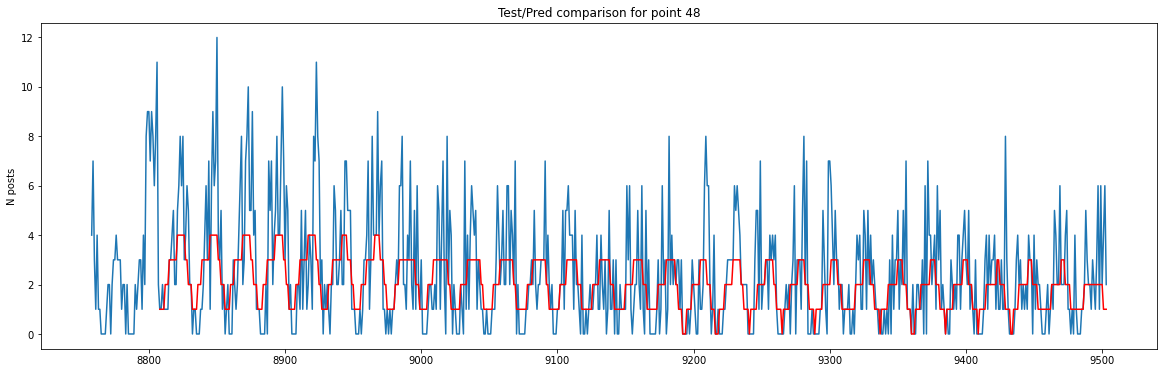

In [62]:
lstm_forecasts = ([np.nan] * (len(data) - len(forecasts[-1]))) + forecasts[-1]

fig = plt.figure(figsize =(20, 6))

n_2_show = len(data) - len(forecasts[-1]) - 50

plt.plot(data[n_2_show:])
plt.plot(lstm_forecasts, color='r')

plt.title(f'Test/Pred comparison for point {i}')
plt.xlabel("")
plt.ylabel("N posts")

Text(0, 0.5, 'N posts')

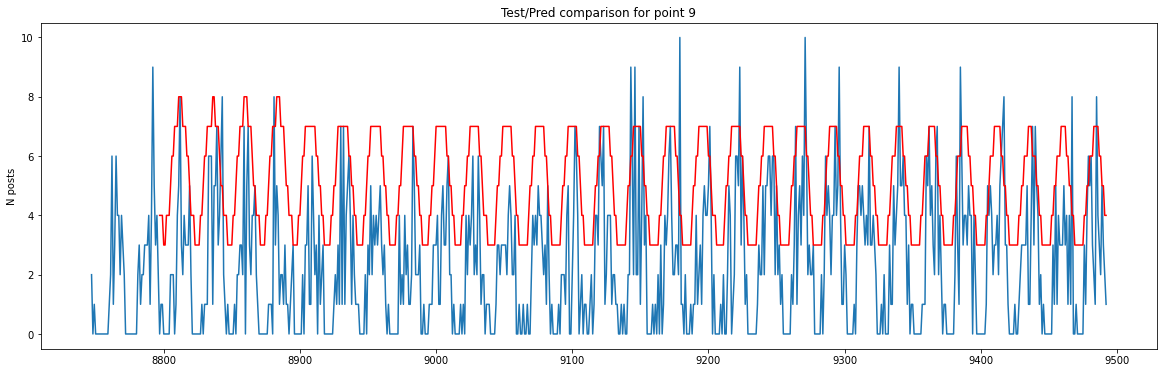

In [46]:
lstm_forecasts = ([np.nan] * (len(data) - len(forecasts[-1]))) + forecasts[-1]

fig = plt.figure(figsize =(20, 6))

n_2_show = len(data) - len(forecasts[-1]) - 50

plt.plot(data[n_2_show:])
plt.plot(lstm_forecasts, color='r')

plt.title(f'Test/Pred comparison for point {i}')
plt.xlabel("")
plt.ylabel("N posts")

Training models for each group of data

In [ ]:
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast

        forecast = array(forecasts[i])

        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inv_diff = [int(x) for x in inv_diff]
        # store
        inverted.append(inv_diff)
    return inverted


forecasts_arr = []
models_list = []

for i in tqdm(range(len(train_data_list))):

    n_lag = 24 * 29
    n_seq = 24 * 29 # 7 days with predicting each hour
    n_test = 1
    n_epochs = 2
    n_batch = 1
    n_neurons = 4

    data = fill_dates(train_data_list[i])
    data = data['n_posts']

    data_idx = train_data_list[i].index
    scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

    model, history_loss, history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    forecasts = make_forecasts(model, n_batch, test, n_lag, n_seq)
    forecasts = inverse_transform(data, forecasts, scaler, n_test+2)

    forecasts_arr.append(forecasts[0])
    models_list.append(model)

  0%|          | 0/149 [00:00<?, ?it/s]

7298/7298 [==============================] - 20s 3ms/step - loss: 0.0169 - val_loss: 0.0109


  1%|          | 1/149 [00:43<1:47:55, 43.75s/it]

7298/7298 [==============================] - 28s 4ms/step - loss: 0.0067 - val_loss: 0.0142


  1%|▏         | 2/149 [01:40<2:06:23, 51.59s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0121 - val_loss: 0.0273


  2%|▏         | 3/149 [02:23<1:55:56, 47.64s/it]

7295/7295 [==============================] - 19s 3ms/step - loss: 0.0158 - val_loss: 0.0124


  3%|▎         | 4/149 [03:10<1:53:47, 47.09s/it]

7296/7296 [==============================] - 21s 3ms/step - loss: 0.0327 - val_loss: 0.0465


  3%|▎         | 5/149 [03:54<1:51:11, 46.33s/it]

7299/7299 [==============================] - 18s 3ms/step - loss: 0.0040 - val_loss: 0.0057


  4%|▍         | 6/149 [04:37<1:47:12, 44.98s/it]

7288/7288 [==============================] - 18s 3ms/step - loss: 0.0162 - val_loss: 0.0090


  5%|▍         | 7/149 [05:21<1:45:49, 44.72s/it]

7298/7298 [==============================] - 21s 3ms/step - loss: 0.0271 - val_loss: 0.0181


  5%|▌         | 8/149 [06:06<1:45:11, 44.76s/it]

7295/7295 [==============================] - 19s 3ms/step - loss: 0.0099 - val_loss: 0.0106


  6%|▌         | 9/149 [06:49<1:43:10, 44.22s/it]

7290/7290 [==============================] - 18s 3ms/step - loss: 0.0089 - val_loss: 0.0086


  7%|▋         | 10/149 [07:34<1:42:54, 44.42s/it]

7297/7297 [==============================] - 20s 3ms/step - loss: 0.0109 - val_loss: 0.0083


  7%|▋         | 11/149 [08:17<1:41:06, 43.96s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 3.5904e-04 - val_loss: 0.0015


  8%|▊         | 12/149 [09:01<1:40:47, 44.14s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0124 - val_loss: 0.0360


  9%|▊         | 13/149 [09:44<1:39:16, 43.80s/it]

7298/7298 [==============================] - 20s 3ms/step - loss: 0.0114 - val_loss: 0.0225


  9%|▉         | 14/149 [10:48<1:51:51, 49.72s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0169 - val_loss: 0.0154


 10%|█         | 15/149 [11:32<1:47:14, 48.02s/it]

7299/7299 [==============================] - 18s 3ms/step - loss: 0.0135 - val_loss: 0.0054


 11%|█         | 16/149 [12:14<1:42:48, 46.38s/it]

7299/7299 [==============================] - 18s 2ms/step - loss: 0.0307 - val_loss: 0.0179


 11%|█▏        | 17/149 [12:58<1:40:29, 45.68s/it]

7298/7298 [==============================] - 18s 3ms/step - loss: 0.0051 - val_loss: 0.0062


 12%|█▏        | 18/149 [13:40<1:37:14, 44.54s/it]

7295/7295 [==============================] - 19s 3ms/step - loss: 0.0086 - val_loss: 0.0109


 13%|█▎        | 19/149 [14:22<1:34:27, 43.59s/it]

7292/7292 [==============================] - 18s 3ms/step - loss: 0.0045 - val_loss: 0.0068


 13%|█▎        | 20/149 [15:02<1:31:50, 42.72s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0096 - val_loss: 0.0068


 14%|█▍        | 21/149 [15:47<1:32:07, 43.18s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0124 - val_loss: 0.0210


 15%|█▍        | 22/149 [16:31<1:32:03, 43.49s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0047 - val_loss: 0.0055


 15%|█▌        | 23/149 [17:15<1:31:48, 43.72s/it]

7299/7299 [==============================] - 18s 3ms/step - loss: 0.0191 - val_loss: 0.0077


 16%|█▌        | 24/149 [17:58<1:30:32, 43.46s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0147 - val_loss: 0.0387


 17%|█▋        | 25/149 [18:40<1:29:05, 43.11s/it]

7297/7297 [==============================] - 19s 3ms/step - loss: 0.0017 - val_loss: 0.0021


 17%|█▋        | 26/149 [19:23<1:28:24, 43.13s/it]

7298/7298 [==============================] - 18s 3ms/step - loss: 0.0093 - val_loss: 0.0092


 18%|█▊        | 27/149 [20:06<1:27:27, 43.01s/it]

7295/7295 [==============================] - 19s 3ms/step - loss: 0.0163 - val_loss: 0.0195


 19%|█▉        | 28/149 [20:50<1:27:27, 43.37s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0070 - val_loss: 0.0201


 19%|█▉        | 29/149 [21:35<1:27:39, 43.83s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0178 - val_loss: 0.0120


 20%|██        | 30/149 [22:19<1:26:41, 43.71s/it]

7298/7298 [==============================] - 19s 3ms/step - loss: 0.0136 - val_loss: 0.0107


 21%|██        | 31/149 [23:02<1:25:36, 43.53s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0159 - val_loss: 0.0069


 21%|██▏       | 32/149 [23:46<1:25:16, 43.73s/it]

7285/7285 [==============================] - 19s 3ms/step - loss: 0.0277 - val_loss: 0.0203


 22%|██▏       | 33/149 [24:51<1:37:06, 50.23s/it]

7298/7298 [==============================] - 20s 3ms/step - loss: 0.0116 - val_loss: 0.0157


 23%|██▎       | 34/149 [25:36<1:32:48, 48.42s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0184 - val_loss: 0.0307


 23%|██▎       | 35/149 [26:21<1:30:35, 47.68s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0167 - val_loss: 0.0133


 24%|██▍       | 36/149 [27:06<1:27:45, 46.60s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0037 - val_loss: 0.0038


 25%|██▍       | 37/149 [28:11<1:37:46, 52.38s/it]

7292/7292 [==============================] - 20s 3ms/step - loss: 0.0028 - val_loss: 0.0023


 26%|██▌       | 38/149 [28:56<1:32:26, 49.96s/it]

7299/7299 [==============================] - 19s 3ms/step - loss: 0.0117 - val_loss: 0.0105


 26%|██▌       | 39/149 [29:40<1:28:21, 48.19s/it]

7298/7298 [==============================] - 20s 3ms/step - loss: 0.0110 - val_loss: 0.0033


 27%|██▋       | 40/149 [30:44<1:36:11, 52.95s/it]

7298/7298 [==============================] - 20s 3ms/step - loss: 0.0109 - val_loss: 0.0092


 28%|██▊       | 41/149 [31:28<1:30:29, 50.28s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0050 - val_loss: 0.0042


 28%|██▊       | 42/149 [32:34<1:38:00, 54.96s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0186 - val_loss: 0.0162


 29%|██▉       | 43/149 [33:18<1:31:29, 51.79s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0258 - val_loss: 0.0449


 30%|██▉       | 44/149 [34:23<1:37:27, 55.69s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0133 - val_loss: 0.0187


 30%|███       | 45/149 [35:07<1:30:18, 52.10s/it]

7291/7291 [==============================] - 21s 3ms/step - loss: 0.0078 - val_loss: 0.0128


 31%|███       | 46/149 [35:52<1:25:59, 50.09s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0036 - val_loss: 0.0431


 32%|███▏      | 47/149 [37:00<1:34:20, 55.50s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0080 - val_loss: 0.0163


 32%|███▏      | 48/149 [38:07<1:39:01, 58.83s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0194 - val_loss: 0.0135


 33%|███▎      | 49/149 [39:32<1:51:22, 66.83s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0045 - val_loss: 0.0035


 34%|███▎      | 50/149 [40:37<1:49:21, 66.27s/it]

7283/7283 [==============================] - 20s 3ms/step - loss: 0.0042 - val_loss: 0.0031


 34%|███▍      | 51/149 [41:42<1:47:32, 65.84s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0143 - val_loss: 0.0063


 35%|███▍      | 52/149 [42:27<1:36:14, 59.53s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0256 - val_loss: 0.0133


 36%|███▌      | 53/149 [43:12<1:28:27, 55.28s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0400 - val_loss: 0.0437


 36%|███▌      | 54/149 [43:56<1:22:08, 51.88s/it]

7298/7298 [==============================] - 19s 3ms/step - loss: 0.0080 - val_loss: 0.0103


 37%|███▋      | 55/149 [44:39<1:17:08, 49.23s/it]

7293/7293 [==============================] - 20s 3ms/step - loss: 0.0246 - val_loss: 0.0221


 38%|███▊      | 56/149 [45:23<1:13:53, 47.68s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0205 - val_loss: 0.0133


 38%|███▊      | 57/149 [46:07<1:11:17, 46.49s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0299 - val_loss: 0.0140


 39%|███▉      | 58/149 [47:32<1:28:12, 58.16s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0081 - val_loss: 0.0081


 40%|███▉      | 59/149 [48:39<1:31:00, 60.68s/it]

7290/7290 [==============================] - 21s 3ms/step - loss: 0.0072 - val_loss: 0.0065


 40%|████      | 60/149 [50:04<1:40:57, 68.06s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0111 - val_loss: 0.0190


 41%|████      | 61/149 [50:48<1:29:16, 60.87s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0111 - val_loss: 0.0101


 42%|████▏     | 62/149 [51:34<1:21:26, 56.17s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0043 - val_loss: 0.0069


 42%|████▏     | 63/149 [52:38<1:24:03, 58.65s/it]

7298/7298 [==============================] - 20s 3ms/step - loss: 0.0336 - val_loss: 0.0276


 43%|████▎     | 64/149 [53:23<1:17:03, 54.40s/it]

7290/7290 [==============================] - 20s 3ms/step - loss: 0.0039 - val_loss: 0.0032


 44%|████▎     | 65/149 [54:06<1:11:45, 51.26s/it]

7298/7298 [==============================] - 21s 3ms/step - loss: 0.0155 - val_loss: 0.0119


 44%|████▍     | 66/149 [54:53<1:09:00, 49.89s/it]

7298/7298 [==============================] - 21s 3ms/step - loss: 0.0256 - val_loss: 0.0197


 45%|████▍     | 67/149 [55:38<1:06:07, 48.39s/it]

7279/7279 [==============================] - 20s 3ms/step - loss: 0.0110 - val_loss: 0.0111


 46%|████▌     | 68/149 [56:23<1:03:59, 47.40s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0085 - val_loss: 0.0116


 46%|████▋     | 69/149 [57:08<1:02:07, 46.60s/it]

7299/7299 [==============================] - 24s 3ms/step - loss: 0.0047 - val_loss: 0.0040


 47%|████▋     | 70/149 [58:13<1:08:52, 52.31s/it]

7299/7299 [==============================] - 20s 3ms/step - loss: 0.0038 - val_loss: 0.0034


 48%|████▊     | 71/149 [59:19<1:13:09, 56.28s/it]

7298/7298 [==============================] - 21s 3ms/step - loss: 0.0099 - val_loss: 0.0150


 48%|████▊     | 72/149 [1:00:45<1:23:29, 65.05s/it]

7291/7291 [==============================] - 23s 3ms/step - loss: 0.0070 - val_loss: 0.0095


 49%|████▉     | 73/149 [1:02:12<1:30:47, 71.68s/it]

7288/7288 [==============================] - 22s 3ms/step - loss: 0.0033 - val_loss: 0.0237


 50%|████▉     | 74/149 [1:03:37<1:34:43, 75.78s/it]

7296/7296 [==============================] - 21s 3ms/step - loss: 0.0381 - val_loss: 0.0219


 50%|█████     | 75/149 [1:05:02<1:36:59, 78.65s/it]

7291/7291 [==============================] - 21s 3ms/step - loss: 0.0125 - val_loss: 0.0221


 51%|█████     | 76/149 [1:06:09<1:31:15, 75.01s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0056 - val_loss: 0.0070


 52%|█████▏    | 77/149 [1:07:16<1:27:02, 72.53s/it]

7289/7289 [==============================] - 23s 3ms/step - loss: 0.0292 - val_loss: 0.0198


 52%|█████▏    | 78/149 [1:08:23<1:24:01, 71.00s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0292 - val_loss: 0.0441


 53%|█████▎    | 79/149 [1:09:30<1:21:14, 69.64s/it]

7290/7290 [==============================] - 22s 3ms/step - loss: 0.0086 - val_loss: 0.0162


 54%|█████▎    | 80/149 [1:10:35<1:18:47, 68.52s/it]

7298/7298 [==============================] - 22s 3ms/step - loss: 0.0156 - val_loss: 0.0175


 54%|█████▍    | 81/149 [1:12:01<1:23:24, 73.60s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0156 - val_loss: 0.0169


 55%|█████▌    | 82/149 [1:13:09<1:20:26, 72.04s/it]

7289/7289 [==============================] - 22s 3ms/step - loss: 0.0014 - val_loss: 0.0021


 56%|█████▌    | 83/149 [1:14:16<1:17:25, 70.39s/it]

7299/7299 [==============================] - 21s 3ms/step - loss: 0.0040 - val_loss: 0.0101


 56%|█████▋    | 84/149 [1:15:22<1:14:43, 68.98s/it]

7291/7291 [==============================] - 22s 3ms/step - loss: 0.0289 - val_loss: 0.0181


 57%|█████▋    | 85/149 [1:16:28<1:12:48, 68.26s/it]

7298/7298 [==============================] - 23s 3ms/step - loss: 0.0166 - val_loss: 0.0174


 58%|█████▊    | 86/149 [1:17:18<1:05:48, 62.67s/it]

7297/7297 [==============================] - 24s 3ms/step - loss: 0.0051 - val_loss: 0.0053


 58%|█████▊    | 87/149 [1:18:26<1:06:35, 64.45s/it]

7291/7291 [==============================] - 23s 3ms/step - loss: 0.0021 - val_loss: 0.0025


 59%|█████▉    | 88/149 [1:19:52<1:12:00, 70.82s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0250 - val_loss: 0.0189


 60%|█████▉    | 89/149 [1:21:18<1:15:20, 75.34s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0025 - val_loss: 0.0081


 60%|██████    | 90/149 [1:22:25<1:11:36, 72.82s/it]

7298/7298 [==============================] - 23s 3ms/step - loss: 0.0049 - val_loss: 0.0059


 61%|██████    | 91/149 [1:23:53<1:14:42, 77.29s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0148 - val_loss: 0.0275


 62%|██████▏   | 92/149 [1:25:18<1:15:44, 79.72s/it]

7296/7296 [==============================] - 22s 3ms/step - loss: 0.0266 - val_loss: 0.0346


 62%|██████▏   | 93/149 [1:26:24<1:10:34, 75.62s/it]

7298/7298 [==============================] - 25s 3ms/step - loss: 0.0092 - val_loss: 0.0109


 63%|██████▎   | 94/149 [1:27:30<1:06:37, 72.69s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0079 - val_loss: 0.0407


 64%|██████▍   | 95/149 [1:28:19<59:01, 65.58s/it]  

7294/7294 [==============================] - 22s 3ms/step - loss: 0.0032 - val_loss: 0.0021


 64%|██████▍   | 96/149 [1:29:07<53:17, 60.33s/it]

7298/7298 [==============================] - 22s 3ms/step - loss: 0.0121 - val_loss: 0.0104


 65%|██████▌   | 97/149 [1:30:14<53:56, 62.24s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0255 - val_loss: 0.0388


 66%|██████▌   | 98/149 [1:31:20<53:58, 63.51s/it]

7292/7292 [==============================] - 22s 3ms/step - loss: 8.8954e-04 - val_loss: 0.0035


 66%|██████▋   | 99/149 [1:32:26<53:37, 64.35s/it]

7290/7290 [==============================] - 22s 3ms/step - loss: 0.0465 - val_loss: 0.0358


 67%|██████▋   | 100/149 [1:33:52<57:47, 70.76s/it]

7299/7299 [==============================] - 24s 3ms/step - loss: 0.0036 - val_loss: 0.0103


 68%|██████▊   | 101/149 [1:34:46<52:39, 65.82s/it]

7297/7297 [==============================] - 23s 3ms/step - loss: 0.0113 - val_loss: 0.0088


 68%|██████▊   | 102/149 [1:35:55<52:11, 66.63s/it]

7299/7299 [==============================] - 23s 3ms/step - loss: 0.0140 - val_loss: 0.0135


 69%|██████▉   | 103/149 [1:36:44<47:06, 61.44s/it]

7294/7294 [==============================] - 23s 3ms/step - loss: 0.0094 - val_loss: 0.0171


 70%|██████▉   | 104/149 [1:37:51<47:22, 63.16s/it]

7291/7291 [==============================] - 23s 3ms/step - loss: 0.0024 - val_loss: 0.0044


 70%|███████   | 105/149 [1:39:17<51:14, 69.87s/it]

7298/7298 [==============================] - 23s 3ms/step - loss: 0.0105 - val_loss: 0.0098


 71%|███████   | 106/149 [1:40:26<49:48, 69.51s/it]

7294/7294 [==============================] - 23s 3ms/step - loss: 0.0186 - val_loss: 0.0148


 72%|███████▏  | 107/149 [1:41:15<44:29, 63.57s/it]

7291/7291 [==============================] - 23s 3ms/step - loss: 0.0232 - val_loss: 0.0246


 72%|███████▏  | 108/149 [1:42:41<47:57, 70.19s/it]

7296/7296 [==============================] - 24s 3ms/step - loss: 0.0146 - val_loss: 0.0203


 73%|███████▎  | 109/149 [1:44:07<49:51, 74.78s/it]

7299/7299 [==============================] - 24s 3ms/step - loss: 0.0242 - val_loss: 0.0183


 74%|███████▍  | 110/149 [1:45:15<47:26, 72.99s/it]

7293/7293 [==============================] - 22s 3ms/step - loss: 0.0035 - val_loss: 0.0046


 74%|███████▍  | 111/149 [1:46:22<45:03, 71.15s/it]

7296/7296 [==============================] - 25s 3ms/step - loss: 0.0133 - val_loss: 0.0112


 75%|███████▌  | 112/149 [1:47:50<47:00, 76.22s/it]

7280/7280 [==============================] - 23s 3ms/step - loss: 0.0089 - val_loss: 0.0111


 76%|███████▌  | 113/149 [1:49:16<47:24, 79.00s/it]

7292/7292 [==============================] - 24s 3ms/step - loss: 0.0062 - val_loss: 0.0103


 77%|███████▋  | 114/149 [1:50:24<44:13, 75.80s/it]

7297/7297 [==============================] - 22s 3ms/step - loss: 0.0032 - val_loss: 0.0038


 77%|███████▋  | 115/149 [1:51:31<41:28, 73.18s/it]

7278/7278 [==============================] - 22s 3ms/step - loss: 0.0023 - val_loss: 0.0029


 78%|███████▊  | 116/149 [1:52:38<39:13, 71.33s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0035 - val_loss: 0.0014


 79%|███████▊  | 117/149 [1:53:44<37:12, 69.78s/it]

7298/7298 [==============================] - 23s 3ms/step - loss: 0.0062 - val_loss: 0.0068


 79%|███████▉  | 118/149 [1:54:35<33:08, 64.15s/it]

7294/7294 [==============================] - 23s 3ms/step - loss: 0.0052 - val_loss: 0.0129


 80%|███████▉  | 119/149 [1:56:01<35:19, 70.64s/it]

7291/7291 [==============================] - 22s 3ms/step - loss: 0.0107 - val_loss: 0.0127


 81%|████████  | 120/149 [1:57:08<33:36, 69.52s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0039 - val_loss: 0.0042


 81%|████████  | 121/149 [1:58:15<32:07, 68.85s/it]

7289/7289 [==============================] - 21s 3ms/step - loss: 0.0022 - val_loss: 0.0017


 82%|████████▏ | 122/149 [1:59:02<27:57, 62.14s/it]

7290/7290 [==============================] - 21s 3ms/step - loss: 0.0040 - val_loss: 0.0062


 83%|████████▎ | 123/149 [2:00:09<27:34, 63.65s/it]

7287/7287 [==============================] - 24s 3ms/step - loss: 0.0143 - val_loss: 0.0139


 83%|████████▎ | 124/149 [2:01:01<25:04, 60.19s/it]

7299/7299 [==============================] - 22s 3ms/step - loss: 0.0077 - val_loss: 0.0086


 84%|████████▍ | 125/149 [2:02:08<24:50, 62.11s/it]

7299/7299 [==============================] - 25s 3ms/step - loss: 0.0052 - val_loss: 0.0059


 85%|████████▍ | 126/149 [2:03:33<26:30, 69.15s/it]

7296/7296 [==============================] - 21s 3ms/step - loss: 0.0373 - val_loss: 0.0462


 85%|████████▌ | 127/149 [2:04:41<25:11, 68.72s/it]

7297/7297 [==============================] - 23s 3ms/step - loss: 0.0250 - val_loss: 0.0250


 86%|████████▌ | 128/149 [2:05:49<23:58, 68.52s/it]

7292/7292 [==============================] - 23s 3ms/step - loss: 0.0174 - val_loss: 0.0471


 87%|████████▋ | 129/149 [2:06:57<22:47, 68.40s/it]

7287/7287 [==============================] - 23s 3ms/step - loss: 0.0050 - val_loss: 0.0092


 87%|████████▋ | 130/149 [2:08:05<21:35, 68.21s/it]

7299/7299 [==============================] - 23s 3ms/step - loss: 0.0095 - val_loss: 0.0161


 88%|████████▊ | 131/149 [2:09:31<22:01, 73.44s/it]

7292/7292 [==============================] - 23s 3ms/step - loss: 0.0192 - val_loss: 0.0382


 89%|████████▊ | 132/149 [2:10:56<21:50, 77.09s/it]

7296/7296 [==============================] - 23s 3ms/step - loss: 0.0208 - val_loss: 0.0236


 89%|████████▉ | 133/149 [2:12:22<21:14, 79.64s/it]

7290/7290 [==============================] - 24s 3ms/step - loss: 0.0094 - val_loss: 0.0132


 90%|████████▉ | 134/149 [2:13:30<19:04, 76.33s/it]

7298/7298 [==============================] - 23s 3ms/step - loss: 0.0169 - val_loss: 0.0293


 91%|█████████ | 135/149 [2:14:21<16:02, 68.78s/it]

7299/7299 [==============================] - 23s 3ms/step - loss: 0.0153 - val_loss: 0.0214


 91%|█████████▏| 136/149 [2:15:47<16:00, 73.87s/it]

7292/7292 [==============================] - 24s 3ms/step - loss: 0.0084 - val_loss: 0.0078


 92%|█████████▏| 137/149 [2:17:13<15:29, 77.42s/it]

7291/7291 [==============================] - 25s 3ms/step - loss: 0.0041 - val_loss: 0.0046


 93%|█████████▎| 138/149 [2:18:10<13:05, 71.41s/it]

7296/7296 [==============================] - 24s 3ms/step - loss: 0.0175 - val_loss: 0.0225


 93%|█████████▎| 139/149 [2:19:19<11:44, 70.48s/it]

7293/7293 [==============================] - 23s 3ms/step - loss: 0.0076 - val_loss: 0.0096


 94%|█████████▍| 140/149 [2:20:44<11:15, 75.03s/it]

7291/7291 [==============================] - 23s 3ms/step - loss: 0.0069 - val_loss: 0.0116


 95%|█████████▍| 141/149 [2:22:10<10:25, 78.20s/it]

7295/7295 [==============================] - 23s 3ms/step - loss: 0.0082 - val_loss: 0.0301


 95%|█████████▌| 142/149 [2:23:18<08:45, 75.10s/it]

7283/7283 [==============================] - 23s 3ms/step - loss: 0.0121 - val_loss: 0.0125


 96%|█████████▌| 143/149 [2:24:43<07:49, 78.19s/it]

7292/7292 [==============================] - 23s 3ms/step - loss: 0.0011 - val_loss: 0.0011


 97%|█████████▋| 144/149 [2:25:50<06:14, 74.91s/it]

7290/7290 [==============================] - 22s 3ms/step - loss: 0.0060 - val_loss: 0.0104


 97%|█████████▋| 145/149 [2:26:39<04:28, 67.08s/it]

7299/7299 [==============================] - 23s 3ms/step - loss: 0.0044 - val_loss: 0.0209


 98%|█████████▊| 146/149 [2:27:47<03:21, 67.22s/it]

7298/7298 [==============================] - 22s 3ms/step - loss: 0.0058 - val_loss: 0.0091


 99%|█████████▊| 147/149 [2:28:55<02:15, 67.56s/it]

7279/7279 [==============================] - 22s 3ms/step - loss: 0.0083 - val_loss: 0.0142


 99%|█████████▉| 148/149 [2:30:02<01:07, 67.39s/it]

7297/7297 [==============================] - 23s 3ms/step - loss: 2.6726e-04 - val_loss: 0.0275


100%|██████████| 149/149 [2:31:10<00:00, 60.88s/it]


# Predicting using trained models

In [ ]:
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inv_diff = [abs(int(x)) for x in inv_diff]
        # store
        inverted.append(inv_diff)
    return inverted


valid_forecasts_list = []
dates_forecast_list = []

for i in tqdm(range(len(train_data_list))):
    # get train data + valid and train dates
    
    data = fill_dates(train_data_list[i])
    data = data['n_posts']

    data_idx = train_data_list[i].index
    valid_idx = valid_data_list[i].index 

    # scaling + division of train data + forecasting
    scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)
    forecasts = make_forecasts(models_list[i], n_batch, test, n_lag, n_seq)
    
    # computing needed forecast length (consider already forcasted values)
    start = max(data_idx)
    end = max(valid_idx)
    seconds = (end-start).total_seconds()
    hours = int(seconds // 3600) + 1
    date_generated = [datetime.strptime(str(start), "%Y-%m-%d %H:%M:%S") + relativedelta(hours=x) for x in range(0,hours)]
    date_generated = date_generated[1::]
    forecast_length = len(date_generated) - len(forecasts[0]) # number of steps in future prediction

    # inverting forecast for test to get oroginally-scaled data for next inversions
    forecast_list = inverse_transform(data, forecasts, scaler, n_test+2)[0]
    # now current input data for model is prediction from prev step
    cur_data = forecasts[0]

    if forecast_length > 0:
        for j in range(forecast_length):
            # make forecast for cur batch
            cur_forecast = forecast_lstm(model, array(cur_data), n_batch)

            # invert current forecast to get inverted new value
            inverted_cur_forecast = inverse_transform(forecast_list[j:], [cur_forecast], scaler, n_test+2)[0]
            inverted_new_val = inverted_cur_forecast[len(inverted_cur_forecast)-1]
            # saving new prediction in preds list
            forecast_list.append(inverted_new_val)

            # take last value of the original cur forecast
            new_val = cur_forecast[len(cur_forecast)-1]
            # erase 0-th element and add new original forecast to data for next predictions
            cur_data = cur_data[1::]
            cur_data.append(new_val)
            
    else:
        small_forecast_data_range = len(forecasts[0])
        date_generated = [datetime.strptime(str(start), "%Y-%m-%d %H:%M:%S") + relativedelta(hours=x) for x in range(0,small_forecast_data_range)]
        date_generated = date_generated[1::]


    #forecast_list = inverse_transform(list(test[0]) + forecast_list[:-n_seq], [forecast_list], scaler, n_test+2)
    #forecast_list = inverse_transform(data, [forecast_list], scaler, n_test+2)

    valid_forecasts_list.append(forecast_list)
    dates_forecast_list.append(date_generated)

100%|██████████| 149/149 [02:40<00:00,  1.08s/it]


In [ ]:
errors_list = []
result_dfs_list = []

for i in range(len(valid_data_list)):
    
    # get dates, sums and forecast sums for i-th point
    dates_valid = [str(x) for x in valid_data_list[i].index]
    sums = [x[0] for x in valid_data_list[i].values]

    dates_forecast = [str(x) for x in dates_forecast_list[i]]
    forecast = valid_forecasts_list[i]
    
    predictions = []
    targets = []
    min_n_posts = min(train_data_list[i].n_posts.values)
    error_list = []

    for j in range(len(sums)):

        # for each date of current point get "ground truth" and "pred" sum
        # and compute metric based on them 
        cur_date = dates_valid[j] 
        ground_truth_sum = sums[j]

        idx = dates_forecast.index(cur_date) # getting index for valid date in all dates range
        pred_sum = forecast[idx]
        if pred_sum == 0:
            pred_sum = min_n_posts

        error_list.append(abs(pred_sum - ground_truth_sum) / pred_sum)
        predictions.append(int(pred_sum))
        targets.append(ground_truth_sum)
    
    errors_list.append(np.mean(error_list))
    
    result_dfs_list.append(pd.DataFrame(list(zip(dates_valid, targets, predictions)), columns =['date','target','prediction']))

# Results visualization

Estimation of metric for each point considered

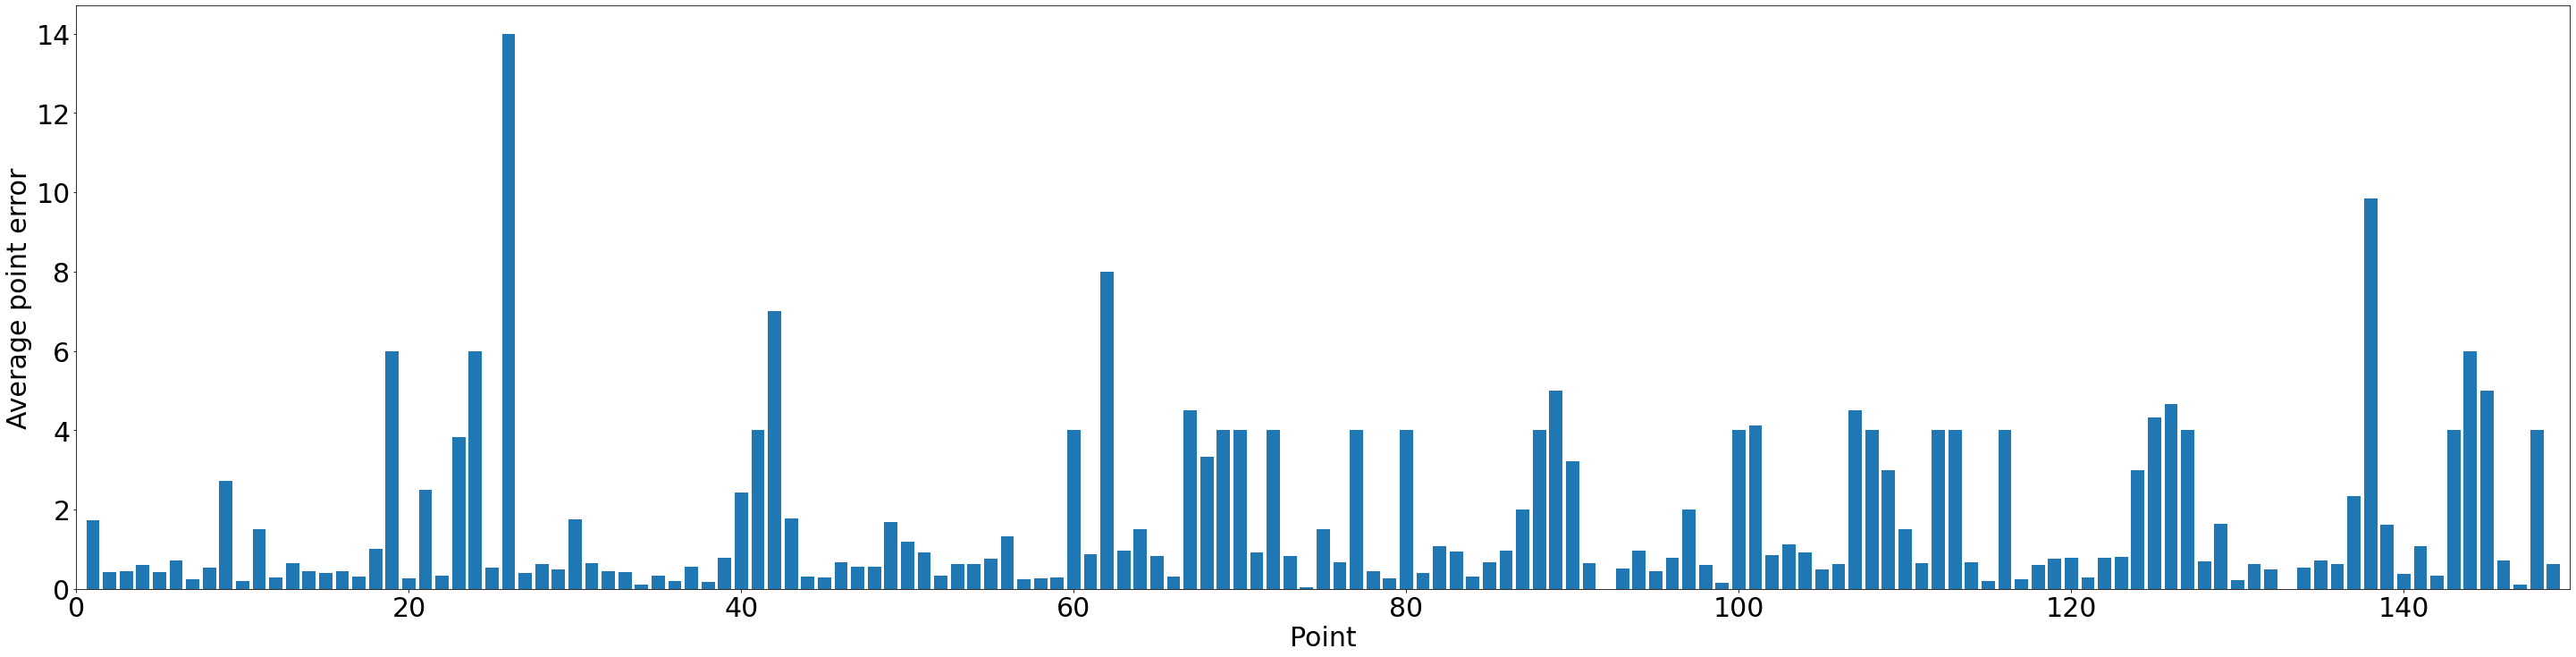

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)

# Figure Size
fig = plt.figure(figsize =(50, 12))
 
# Horizontal Bar Plot
plt.bar(range(1,len(errors_list)+1), errors_list)
plt.xlim([0, len(errors_list)+1])
plt.ylabel('Average point error')
plt.xlabel('Point')


# Show Plot
plt.show()

In [ ]:
result_dfs_list[1]

,date,target,prediction
0,2020-02-24 11:00:00,12,15
1,2020-02-01 10:00:00,7,15
2,2020-02-11 05:00:00,9,10
3,2020-02-08 09:00:00,10,14
4,2020-02-08 21:00:00,5,12
5,2020-02-09 09:00:00,5,14


In [ ]:
result_dfs_list[1].target.sum()

48

Creating dataframe for visualisation

In [ ]:
from shapely import wkb
point_coords = [wkb.loads(x, hex=True) for x in points_list]
target_sum = []
pred_sum = []
lat = []
lon = []
for i in range(len(result_dfs_list)):
    target_sum.append(result_dfs_list[i].target.sum())
    pred_sum.append(result_dfs_list[i].prediction.sum())
    lon.append(point_coords[i].x)
    lat.append(point_coords[i].y)

data_4_vis = pd.DataFrame(list(zip(lon, lat, target_sum, pred_sum)), columns =['lon','lat','target_sum', 'pred_sum'])

Here we find a posts number sum for each considered point and compare predicted and target results for each point

In [ ]:
data_4_vis

,lon,lat,target_sum,pred_sum
0,30.331616,59.934863,71,32
1,30.329370,59.940488,48,80
2,30.297929,59.905597,92,135
3,30.356319,59.921359,173,3669
4,30.315895,59.939363,52,96
...,...,...,...,...
144,30.205851,59.991070,12,2
145,30.291191,59.937113,191,74
146,30.313649,59.953984,18,21
147,30.313649,59.965226,5,7


Here we can see each poligon presented in test set (blue circle). We can see information about each poligon by clicking on the circle marker. Here we can compare the results of predicted values with target

In [ ]:
import folium

# Mark post locations for 2019-01-01
m = folium.Map([59.9495, 30.320], zoom_start=10)
for index, row in data_4_vis.iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                        radius=5,
                        popup=("Lat: " + str(row['lat']) + "<br> Lon: " + str(row['lon']) + "<br> Target N posts: " + str(int(row['target_sum'])) + "<br> Predicted N posts:" +str(int(row['pred_sum']))),
                        fill_color="#3db7e4",
                       ).add_to(m)
m

Moreover, we can analyse the results by looking at heatmap, which was built based on point location (!)WITH target values as weights. So it's not just a heatmap of locations - it also included information about number of posts, during plot

In [ ]:
from folium.plugins import HeatMap

# convert to (n, 2) nd-array format for heatmap
dfmatrix = data_4_vis[['lat', 'lon', 'target_sum']].values.tolist()
# plot heatmap
m.add_child(HeatMap(dfmatrix, radius=15))
m

Comparing preds and targets for one particular poligon

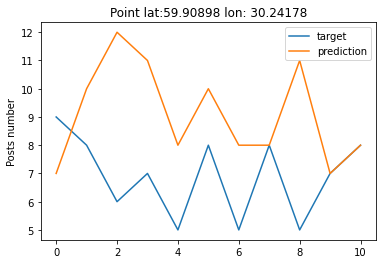

In [ ]:
i=16

y_tar = result_dfs_list[i].target
y_pred = result_dfs_list[i].prediction

plt.plot(y_tar, label = "target")
plt.plot(y_pred, label = "prediction")
plt.ylabel("Posts number")
plt.title(f"Point lat:{lat[i]:.5f} lon: {lon[i]:.5f}")
plt.legend()
plt.show()

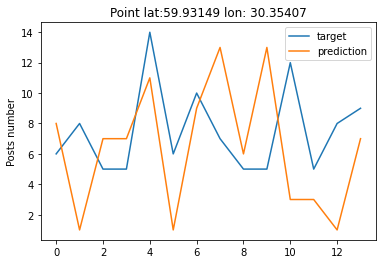

In [ ]:
i=26

y_tar = result_dfs_list[i].target
y_pred = result_dfs_list[i].prediction

plt.plot(y_tar, label = "target")
plt.plot(y_pred, label = "prediction")
plt.ylabel("Posts number")
plt.title(f"Point lat:{lat[i]:.5f} lon: {lon[i]:.5f}")
plt.legend()
plt.show()

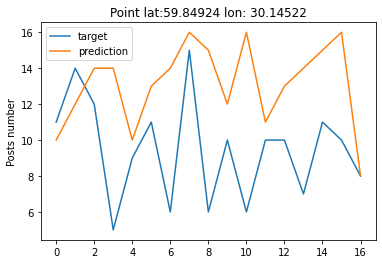

In [ ]:
i=43 

y_tar = result_dfs_list[i].target
y_pred = result_dfs_list[i].prediction

plt.plot(y_tar, label = "target")
plt.plot(y_pred, label = "prediction")
plt.ylabel("Posts number")
plt.title(f"Point lat:{lat[i]:.5f} lon: {lon[i]:.5f}")
plt.legend()
plt.show()

In [ ]:
for i in range(len(result_dfs_list)):
    result_dfs_list[i].to_csv(f"pred_data/pred_{i}.csv")

!zip -r /content/pred_data.zip /content/pred_data

# Saved metrics during parametrs grid search

TEST DATA: Final metric for solution with test for pred (n_seq = 24 * 29, 2 epochs, 4 neurons):

In [ ]:
np.mean(error_list)

0.7073996774615564

TEST DATA: Final metric for solution with test for pred (n_seq = 24 * 29, 2 epochs, 4 neurons):

In [ ]:
np.mean(error_list)

1.0908652770704461

Final metric for solution with test for pred (n_seq = 24 * 29, 2 epochs, 4 neurons):

In [ ]:
np.mean(error_list)

0.9974809261703629

Final metric for solution with test for pred (n_seq = 24 * 29, 2 epochs, 12 neurons):

In [ ]:
np.mean(error_list)

1.0945112572604219

Final metric for solution with test for pred (n_seq = 24 * 7, 2 epochs):

In [ ]:
np.mean(error_list)

1.2441659920762373

Final metric for solution with test for pred (n_seq = 24 * 29, 2 epochs):

In [ ]:
np.mean(error_list)

1.0094215613850264

Final metric for solution with test for pred (n_seq = 24 * 7):

In [ ]:
np.mean(error_list)

2.9159652601536936

Final metric for solution with test for pred (2 epoch):

In [ ]:
np.mean(error_list)

2.140239907812921

Final metric for solution with test for pred (1 epoch):

In [ ]:
np.mean(error_list)

3.0385669717523798